In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from load_data import load_data_from_csv
from data_preprocessor.data_preprocessor import CompositeDataPreprocessor, ReduceMemUsageDataPreprocessor, FillNaPreProcessor
from data_preprocessor.feature_engineering import (
    BasicFeaturesPreprocessor,
    DupletsTripletsPreprocessor,
    MovingAvgPreProcessor,
    RemoveIrrelevantFeaturesDataPreprocessor,
    DropTargetNADataPreprocessor,
    FarNearPriceFillNaPreprocessor,
    MovingAvgFillNaPreprocessor,
    RemoveRecordsByStockDateIdPreprocessor,
)
from data_preprocessor.stock_feature_engineering import (
    StockNormalizeFeaturesPreprocessor,
)
from data_preprocessor.polynomial_features import PolynomialFeaturesPreProcessor
from data_preprocessor.stockid_features import StockIdFeaturesPreProcessor
# from data_preprocessor.deep_feature_synthesis import DfsPreProcessor
from data_generator.data_generator import DefaultTrainEvalDataGenerator, ManualKFoldDataGenerator, TimeSeriesKFoldDataGenerator

from model_post_processor.model_post_processor import CompositeModelPostProcessor, SaveModelPostProcessor

from train_pipeline.train_pipeline import DefaultTrainPipeline

from train_pipeline.train_pipeline_callbacks import MAECallback
from utils.scoring_utils import ScoringUtils
from model_pipeline.dummy_models import BaselineEstimator

import numpy as np

import sys
import pandas as pd

from sklearn import preprocessing

from model_pipeline.mlp_pipeline import MLPModelPipelineFactory

In [25]:
N_fold = 5
model_save_dir = './models'

processors = [    
    ReduceMemUsageDataPreprocessor(verbose=True),
    RemoveRecordsByStockDateIdPreprocessor([
        {"stock_id": 19, "date_id": 438},
        {"stock_id": 101, "date_id": 328},
        {"stock_id": 131, "date_id": 35},
        {"stock_id": 158, "date_id": 388},
    ]),
    FarNearPriceFillNaPreprocessor(),
    # BasicFeaturesPreprocessor(),
    # DupletsTripletsPreprocessor(),
    # MovingAvgPreProcessor("wap"),
    # MovingAvgFillNaPreprocessor("wap", 1.0),
    # StockIdFeaturesPreProcessor(),   
    # DTWKMeansPreprocessor(),
    # DfsPreProcessor(),
    # DropTargetNADataPreprocessor(),    
    RemoveIrrelevantFeaturesDataPreprocessor(['stock_id', 'date_id','time_id', 'row_id']),
    # FillNaPreProcessor(1.0),
    # PolynomialFeaturesPreProcessor(),
]


processor = CompositeDataPreprocessor(processors)


In [26]:
# DATA_PATH = '/kaggle/input'
DATA_PATH = '..'
df_train, df_test, revealed_targets, sample_submission = load_data_from_csv(DATA_PATH)
print(df_train.columns)

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id'],
      dtype='object')


In [27]:
raw_data = df_train.copy(deep=True)
# df_train = df_train[:100000]

In [28]:
df_train = raw_data

In [29]:
df_train = processor.apply(df_train)

CompositeDataPreprocessor - original df shape: (5237980, 17)
Processing ReduceMemUsageDataPreprocessor...
Memory usage of dataframe is 679.36 MB
Memory usage after optimization is: 304.72 MB
Decreased by 55.15%
dtypes:
stock_id                     int16
date_id                      int16
seconds_in_bucket            int16
imbalance_size             float32
imbalance_buy_sell_flag       int8
reference_price            float32
matched_size               float32
far_price                  float32
near_price                 float32
bid_price                  float32
bid_size                   float32
ask_price                  float32
ask_size                   float32
wap                        float32
target                     float32
time_id                      int16
row_id                      object
dtype: object
ReduceMemUsageDataPreprocessor took 2.02s. New df shape: (5237980, 17).
Processing RemoveRecordsByStockDateIdPreprocessor...
RemoveRecordsByStockDateIdPreprocessor - removi

In [30]:
print(df_train.columns)
display(df_train)

Index(['seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag',
       'reference_price', 'matched_size', 'far_price', 'near_price',
       'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap', 'target'],
      dtype='object')


,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
0,0,3.180603e+06,1,0.999812,13380277.00,1.000000,1.000000,0.999812,60651.500000,1.000026,8493.030273,1.000000,-3.029704
1,0,1.666039e+05,-1,0.999896,1642214.25,1.000000,1.000000,0.999896,3233.040039,1.000660,20605.089844,1.000000,-5.519986
2,0,3.028799e+05,-1,0.999561,1819368.00,1.000000,1.000000,0.999403,37956.000000,1.000298,18995.000000,1.000000,-8.389950
3,0,1.191768e+07,-1,1.000171,18389746.00,1.000000,1.000000,0.999999,2324.899902,1.000214,479032.406250,1.000000,-4.010201
4,0,4.475500e+05,-1,0.999532,17860614.00,1.000000,1.000000,0.999394,16485.539062,1.000016,434.100006,1.000000,-7.349849
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,540,2.440723e+06,-1,1.000317,28280362.00,0.999734,0.999734,1.000317,32257.039062,1.000434,319862.406250,1.000328,2.310276
5237976,540,3.495105e+05,-1,1.000643,9187699.00,1.000129,1.000386,1.000643,205108.406250,1.000900,93393.070312,1.000819,-8.220077
5237977,540,0.000000e+00,0,0.995789,12725436.00,0.995789,0.995789,0.995789,16790.660156,0.995883,180038.312500,0.995797,1.169443
5237978,540,1.000899e+06,1,0.999210,94773272.00,0.999210,0.999210,0.998970,125631.718750,0.999210,669893.000000,0.999008,-1.540184


In [31]:
feat_dynamic_real = df_train.columns.tolist()
feat_dynamic_real.remove("target")
num_input_features = len(feat_dynamic_real)
print(num_input_features, feat_dynamic_real)

12 ['seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag', 'reference_price', 'matched_size', 'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap']


In [32]:
# should not have any na features
any_na_values_mask = df_train[feat_dynamic_real].isna().any(axis=1)
print(any_na_values_mask.shape, any_na_values_mask[any_na_values_mask].shape)

(5237760,) (0,)


## Normalize features (TODO: normalize by group? stock id?)

In [33]:
normalize_columns = set([
    "imbalance_size",
    "matched_size",
    "bid_size",
    "ask_size",
])
normalize_columns = list(normalize_columns.intersection(set(feat_dynamic_real)))
print(normalize_columns)

['imbalance_size', 'matched_size', 'bid_size', 'ask_size']


In [34]:
model_name = "20240410_mlp_raw"

In [35]:
default_data_generator = DefaultTrainEvalDataGenerator()
k_fold_data_generator = ManualKFoldDataGenerator(n_fold=5)

In [36]:
model_post_processor = CompositeModelPostProcessor([
    SaveModelPostProcessor(save_dir=model_save_dir)
])

In [37]:
print(f"Generate data")
train_dfs, eval_dfs, num_train_eval_sets = k_fold_data_generator.generate(df_train)

models = []
model_res = []

print(f"Start train and tune, num_train_eval_sets: {num_train_eval_sets}")

Generate data
Start train and tune, num_train_eval_sets: 5


In [42]:
mlp_model_pipeline_factory = MLPModelPipelineFactory(model_name, 12)

In [43]:
param = {
            'learning_rate': 0.001,

        }

In [44]:
# X_train_fold, y_train_fold, X_val_fold, y_val_fold = self.model_pipeline.create_XY(train_dfs[fold_index], eval_dfs[fold_index])

Training fold 0 - start


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,713 (264.50 KB)

 Trainable params: 67,713 (264.50 KB)

 Non-trainable params: 0 (0.00 B)

None
Training fold 0 - initialized
Training fold 0 - train size: (4190208, 13), eval size: (1047552, 13)
Training fold 0 - start training
Epoch 1/10
130944/130944 ━━━━━━━━━━━━━━━━━━━━ 1171s 9ms/step - loss: 6.4328 - mae: 6.4328 - val_loss: 6.2357 - val_mae: 6.2357
Epoch 2/10
130944/130944 ━━━━━━━━━━━━━━━━━━━━ 1229s 9ms/step - loss: 6.4105 - mae: 6.4105 - val_loss: 6.2396 - val_mae: 6.2396
Epoch 3/10
130944/130944 ━━━━━━━━━━━━━━━━━━━━ 1272s 10ms/step - loss: 6.4077 - mae: 6.4077 - val_loss: 6.2271 - val_mae: 6.2271
Epoch 4/10
130944/130944 ━━━━━━━━━━━━━━━━━━━━ 451s 3ms/step - loss: 6.4033 - mae: 6.4033 - val_loss: 6.2341 - val_mae: 6.2341
Epoch 5/10
130944/130944 ━━━━━━━━━━━━━━━━━━━━ 319s 2ms/step - loss: 6.4038 - mae: 6.4038 - val_loss: 6.2292 - val_mae: 6.2292
Epoch 6/10
130944/130944 ━━━━━━━━━━━━━━━━━━━━ 379s 3ms/step - loss: 6.4034 - mae: 6.4034 - val_loss: 6.2287 - val_mae: 6.2287
Epoch 7/10
130944/130944 ━━━━━━━━━━━━━━━━━━━━ 521s 4ms/step - loss: 6.3998 - mae: 6.3998 - val_loss: 6

PicklingError: Can't pickle <function Layer._initializer_tracker.<locals>.<lambda> at 0x0000026DD57E2200>: it's not found as keras.src.layers.layer.Layer._initializer_tracker.<locals>.<lambda>

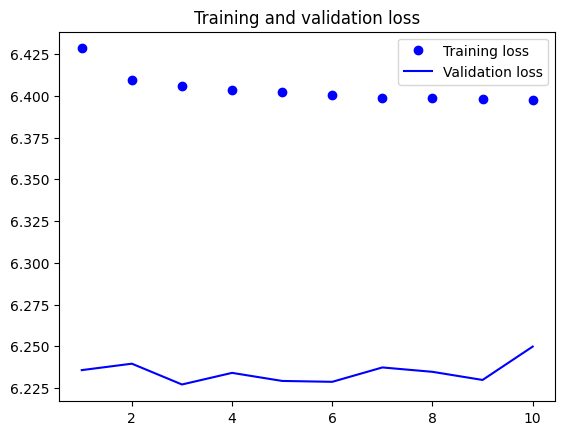

In [45]:
for fold in range(num_train_eval_sets):
    print(f"Training fold {fold} - start")

    model_pipeline = mlp_model_pipeline_factory.create_model_pipeline()
    model_pipeline.init_model(param = param)
    print(f"Training fold {fold} - initialized")

    fold_df_train = train_dfs[fold]
    fold_df_eval = eval_dfs[fold]
    print(f"Training fold {fold} - train size: {fold_df_train.shape}, eval size: {fold_df_eval.shape}")

    # normalize features, scaler per fold, fit on training set, transform both training and validation set
    scaler = preprocessing.StandardScaler()
    scaler.fit(fold_df_train[normalize_columns])
    fold_df_train[normalize_columns] = scaler.transform(fold_df_train[normalize_columns])
    fold_df_eval[normalize_columns] = scaler.transform(fold_df_eval[normalize_columns])

    X_train_fold, y_train_fold, X_val_fold, y_val_fold = model_pipeline.create_XY(train_dfs[fold], eval_dfs[fold])

    print(f"Training fold {fold} - start training")
    train_res = model_pipeline.train(X_train_fold, y_train_fold, X_val_fold, y_val_fold, _)
    fold_model = model_pipeline.get_model()
    models.append(fold_model)
    model_res.append(train_res)
    print(f"Training fold {fold} - finished training")
    
    model_post_processor.process(fold_model, model_pipeline, fold)
    print(f"Training fold {fold} - finished post processing")

    print(f"Training fold {fold} - end")

print(f"finished training, num_train_eval_sets: {num_train_eval_sets}")



In [ ]:
    callback_results = []
    for callback in self.callbacks:
        callback_res = callback.on_callback(models, model_res, train_dfs, eval_dfs, num_train_eval_sets)
        callback_results.append(callback_res)

    return models, model_res, train_dfs, eval_dfs, num_train_eval_sets, callback_results

In [ ]:
pipeline = DefaultTrainPipeline(MLPModelPipelineFactory(model_name), k_fold_data_generator, model_post_processor, [MAECallback()])

In [ ]:
models, model_res, train_dfs, eval_dfs, num_train_eval_sets, callback_results = pipeline.train(df_train)

generate data
start training, num_train_eval_sets: 5
Training fold 0 - start


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,713 (264.50 KB)

 Trainable params: 67,713 (264.50 KB)

 Non-trainable params: 0 (0.00 B)

None
Training fold 0 - initialized
Training fold 0 - train size: (4190313, 13), eval size: (1047579, 13)
Training fold 0 - start training


TypeError: MLPModelPipeline.train() missing 3 required positional arguments: 'eval_X', 'eval_Y', and 'eval_res'

In [ ]:
lgb_avg_mae = ScoringUtils.calculate_mae(lgb_models, lgb_eval_dfs)
print(lgb_avg_mae)